# 機械学習ハンズオン（ワークフロー編）

## ハンズオンの概要

[UCIのAdultデータセット](https://archive.ics.uci.edu/ml/datasets/Adult)を使って、
年齢や職業などのデータから、その人の収入が5万ドル以上あるかどうかの2値分類(binary classification)を行います。

このハンズオンの流れは次のとおりです。
 1. データの取得
 1. データの分析
 1. データの前処理
 1. 学習モデルの作成
 1. 学習モデルの評価


## 事前準備

### ランタイムの確認

Google Colabを使っている場合は、メニューから「ランタイム」→「ランタイムのタイプを変更」を選択して、「ハードウェア アクセラレータ」を「GPU」に設定してください。


### ライブラリのロード

In [1]:
!pip install pandas tensorflow numpy matplotlib seaborn scikit-learn
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## データ取得

pandasのAPIを使ってデータファイルを読み込みます。
 * このファイルにはヘッダー行がないので、ヘッダーは自分で設定します。
 * 不明値を表す "?" はN/Aに変換しておきます。
   * のちほど不明値を処理します。

In [2]:
headers = ('age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income')
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ', names=headers, na_values='?')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


読み込んだデータを表示してみましょう。

In [3]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


意味（詳細は[こちら](https://archive.ics.uci.edu/ml/datasets/Adult)を参照）
 * age: 年齢
 * work-class: 雇用形態
 * fnlwgt: 説明を見たけどわからなかった
 * education: 学歴
 * education-num: 教育を受けた年数
 * marital-status:
 * occupation
 * relationship
 * race
 * sex
 * capital-gain
 * capital-loss
 * hours-per-week
 * native-country
 * income

## データ分析

### ラベルごとのデータ件数

5万ドル未満が約76%あるので、**学習モデルがすべて5万ドル未満と予測しても76%前後の正答率が出てしまう**ことに注意が必要です。

In [22]:
df.groupby('income').size()

income
<=50K    24720
>50K      7841
dtype: int64

In [21]:
df.groupby('income').size() / len(df)

income
<=50K    0.75919
>50K     0.24081
dtype: float64

### 量的変数の分析

#### ラベル別の特徴量の分布

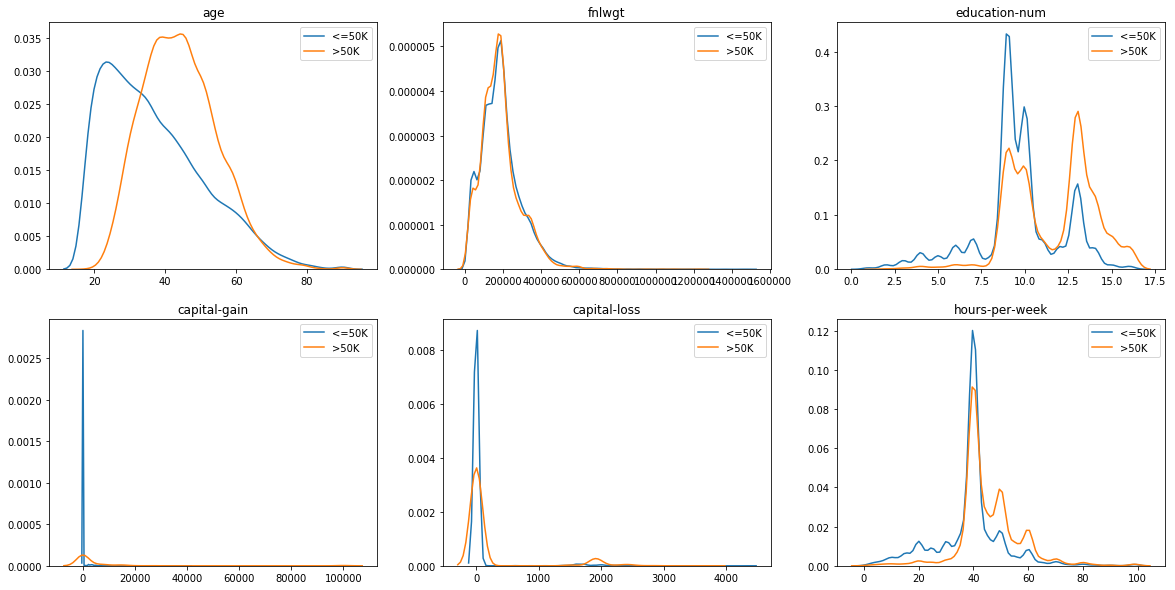

In [11]:
plt.figure(figsize=(20, 10))
features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
for i in range(len(features)):
  plt.subplot(2, 3, i+1)
  plt.title(features[i])
  sns.kdeplot(df[df['income']=='<=50K'][features[i]], label='<=50K')
  sns.kdeplot(df[df['income']=='>50K'][features[i]], label='>50K')


In [0]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


欠損値があるかどうかを調べます。

欠損値があるので、あとでこのレコードを削除します。

In [0]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

### 質的変数の分析

### ラベル別の特徴量の分布

In [14]:
pd.crosstab(index=df['income'], columns=df['workclass'], normalize='columns')

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
income,,,,,,,,
<=50K,0.613542,0.705208,1.0,0.781327,0.442652,0.715073,0.728043,1.0
>50K,0.386458,0.294792,0.0,0.218673,0.557348,0.284927,0.271957,0.0


In [0]:
pd.crosstab(index=df['income'], columns=df['marital-status'], normalize='columns')

marital-status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
income,,,,,,,
<=50K,0.895791,0.565217,0.553152,0.91866,0.954039,0.93561,0.914401
>50K,0.104209,0.434783,0.446848,0.08134,0.045961,0.06439,0.085599


In [0]:
pd.crosstab(index=df['income'], columns=df['occupation'], normalize='columns')

occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
income,,,,,,,,,,,,,,
<=50K,0.865517,0.888889,0.773359,0.515986,0.884306,0.937226,0.875125,0.958422,0.993289,0.550966,0.674884,0.730685,0.695043,0.799624
>50K,0.134483,0.111111,0.226641,0.484014,0.115694,0.062774,0.124875,0.041578,0.006711,0.449034,0.325116,0.269315,0.304957,0.200376


In [0]:
pd.crosstab(index=df['income'], columns=df['relationship'], normalize='columns')

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
income,,,,,,
<=50K,0.551429,0.89693,0.962283,0.98678,0.936738,0.524872
>50K,0.448571,0.10307,0.037717,0.01322,0.063262,0.475128


In [0]:
pd.crosstab(index=df['income'], columns=df['race'], normalize='columns')

race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
income,,,,,
<=50K,0.884244,0.73436,0.87612,0.907749,0.74414
>50K,0.115756,0.26564,0.12388,0.092251,0.25586


In [0]:
pd.crosstab(index=df['income'], columns=df['sex'], normalize='columns')

sex,Female,Male
income,,
<=50K,0.890539,0.694263
>50K,0.109461,0.305737


In [0]:
pd.crosstab(index=df['income'], columns=df['native-country'], normalize='columns')

native-country,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
income,,,,,,,,,,,,,,,,,,,,,
<=50K,0.631579,0.677686,0.733333,0.966102,0.736842,0.971429,0.857143,0.915094,0.666667,0.586207,...,0.891892,0.894737,0.75,0.8,0.607843,0.833333,0.894737,0.754165,0.925373,0.625
>50K,0.368421,0.322314,0.266667,0.033898,0.263158,0.028571,0.142857,0.084906,0.333333,0.413793,...,0.108108,0.105263,0.25,0.2,0.392157,0.166667,0.105263,0.245835,0.074627,0.375


### 特徴量間の関係の分析

#### "education" vs "education-num"
下図から同値だと判断できるため、"education"は除外

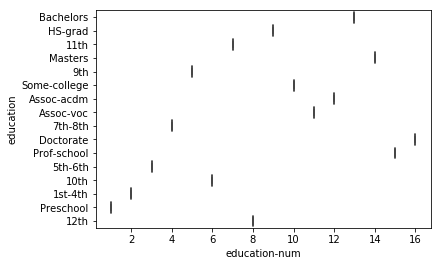

In [0]:
sb.boxplot(y='education', x='education-num', data=df)

In [6]:
pd.crosstab(index=df['relationship'], columns=df['marital-status'], normalize='index')

marital-status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
relationship,,,,,,,
Husband,0.000000,0.000682,0.999318,0.000000,0.000000,0.000000,0.000000
Not-in-family,0.289464,0.000000,0.002047,0.025406,0.566647,0.050572,0.065864
Other-relative,0.112130,0.001019,0.126402,0.032620,0.622834,0.056065,0.048930
Own-child,0.064720,0.000197,0.018745,0.008879,0.884964,0.019534,0.002960
Unmarried,0.464597,0.000000,0.000000,0.037725,0.255659,0.130876,0.111143
Wife,0.000000,0.007653,0.992347,0.000000,0.000000,0.000000,0.000000


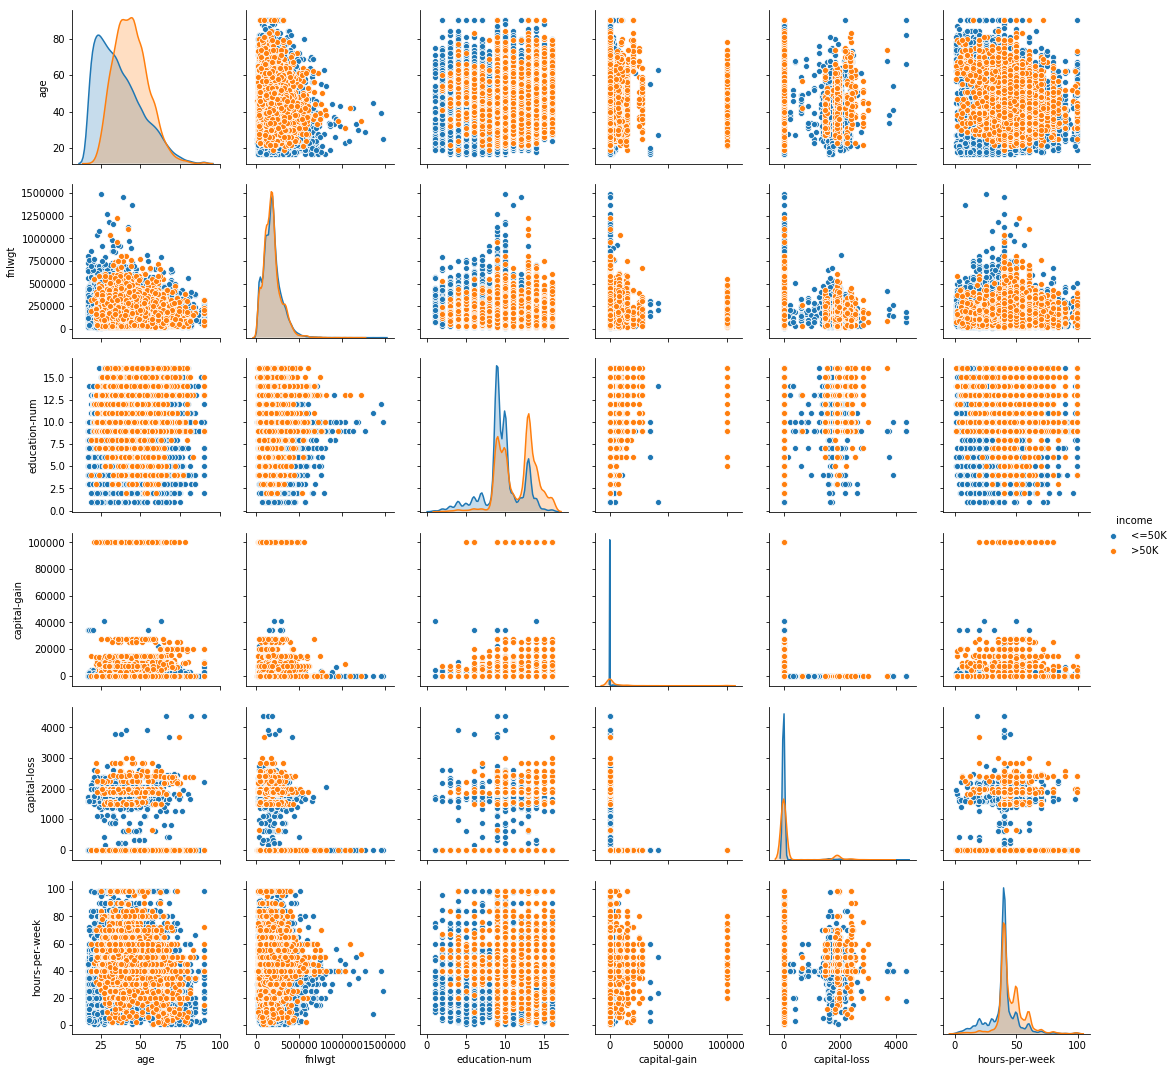

In [0]:
sb.pairplot(df, hue='income')

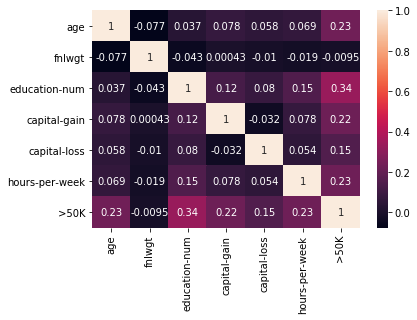

In [0]:
sb.heatmap(df.corr(), annot=True)

In [0]:
df = pd.get_dummies(df)
df.head(10)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_<=50K,income_>50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,37,284582,14,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
6,49,160187,5,0,0,16,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,52,209642,9,0,0,45,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8,31,45781,14,14084,0,50,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,42,159449,13,5178,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [0]:
Y = df.loc['income_>50K']
Y.head(10)

KeyError: 'income_>50K'

In [0]:
drop_columns = ['income', 'fnlwgt', 'race']
xs = pd.get_dummies(df.drop(drop_columns, axis=1))
xs

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,37,14,0,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,49,5,0,0,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,52,9,0,0,45,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8,31,14,14084,0,50,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,42,13,5178,0,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## 学習モデルの作成

### データ分割
データを訓練データ・検証データ・テストデータの3つに分割します。

まず、全体の10%をテストデータに回し、残ったデータの20%を検証データに回します。

In [0]:
train_xs, test_xs, train_ys, test_ys = train_test_split(xs.values, ys.values, test_size=0.1)
print(train_xs.shape, test_xs.shape, train_ys.shape, test_ys.shape)

(29304, 99) (3257, 99) (29304, 1) (3257, 1)


In [0]:
scaler = MinMaxScaler()
scaler.fit(train_xs)
train_xs = scaler.transform(train_xs)
test_xs = scaler.transform(test_xs)

### 学習モデル構築

In [0]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_dim=train_xs.shape[1], activation='sigmoid')
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
hidden_nodes = 128
dropout_rate = 0.2
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=train_xs.shape[1], activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 学習モデルの評価

### 学習実行

実際に学習
エポック（すべての訓練データを1回学習させることを**1エポック**と呼びます）ごとに、訓練データ・検証データそれぞれに対する損失・正答率が出力されます。
 * `loss` : 訓練データの損失
 * `acc` : 訓練データの正答率
 * `val_loss`: 検証データの損失
 * `val_acc`: 検証データの正答率

In [0]:
model = model2
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
hist = model.fit(train_xs, train_ys, batch_size=128, epochs=100, validation_data=(test_xs, test_ys))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6400      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total para

### モデルの評価
訓練データ・学習データに対する損失と正答率をグラフ化してみましょう。

Text(0, 0.5, 'loss')

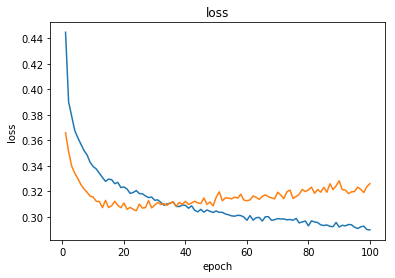

In [0]:
%matplotlib inline
plt.plot(range(1, 101), hist.history["loss"])
plt.plot(range(1, 101), hist.history["val_loss"])
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

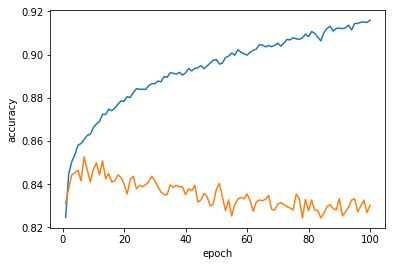

In [0]:
%matplotlib inline
plt.plot(range(1, 101), hist.history["acc"])
plt.plot(range(1, 101), hist.history["val_acc"])
plt.xlabel("epoch")
plt.ylabel("accuracy")